#The Fluties - In The Money (ITM)

The Fluties pays out the top two spots. Let's investigate if we can predict how the top two spots will be.

In [4]:
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

from dotenv import load_dotenv

load_dotenv()
current_year = int(os.getenv('current_year'))
teams = pd.read_csv("processed_teams.csv")

curr_teams = teams.loc[teams["year"] == current_year]
hist_teams = teams.loc[teams["year"] != current_year]

In [12]:
logreg = LogisticRegression()

rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(hist_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "record.overall.wins"]], hist_teams["itm"])

In [13]:
rfe.ranking_

array([1, 1, 1, 1])

In [14]:
sm_over = SMOTE(random_state=10)
sm_X, sm_y = sm_over.fit_resample(hist_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "record.overall.wins"]],  hist_teams["itm"])
logit = sm.Logit(sm_y, sm_X).fit()

Optimization terminated successfully.
         Current function value: 0.556195
         Iterations 6


In [15]:
logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.198     
Dependent Variable:  itm               AIC:               197.1062  
Date:                2022-01-10 22:52  BIC:               209.6494  
No. Observations:    170               Log-Likelihood:    -94.553   
Df Model:            3                 LL-Null:           -117.84   
Df Residuals:        166               LLR p-value:       4.3033e-10
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
scaled_pointsFor      1.0880   0.2626  4.1437 0.0000  0.5734  1.6026
scaled_pointsAgainst -0.6326   0.2086 -3.0326 0.0024 -1.0414 -0.2238
scaled_moves          0.3460   0.1906  1.8152 0.0695 -0.0276  0.7196
record.overall.wins  -0.0519   0.0299 -1.7400 0.0819 -0.1104  0.0066
====================================================================

"""

In [16]:
log_pred = logit.predict(curr_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "record.overall.wins"]])

In [17]:
curr_teams["sm_pred"] = log_pred.values
curr_teams[["abbrev", "playoffSeed", "sm_pred"]]

/tmp/ipykernel_7433/4126382990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_teams["sm_pred"] = log_pred.values


,abbrev,playoffSeed,sm_pred
9,Caw,5,0.827429
19,TOTY,8,0.400789
29,Sith,9,0.168920
39,TMB,11,0.044363
49,Mill,10,0.174049
59,BD,3,0.817326
69,Rock,6,0.332711
79,2021,2,0.775742
89,faq,7,0.439315
99,JJJ,12,0.087653


In [19]:
oversample = SMOTE(random_state=10)
X, y = oversample.fit_resample(hist_teams[["scaled_pointsFor", "scaled_moves", "playoffSeed"]],  hist_teams["itm"])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [21]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [22]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[21  4]
 [ 9 17]]


In [23]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.84      0.76        25
         1.0       0.81      0.65      0.72        26

    accuracy                           0.75        51
   macro avg       0.75      0.75      0.74        51
weighted avg       0.76      0.75      0.74        51



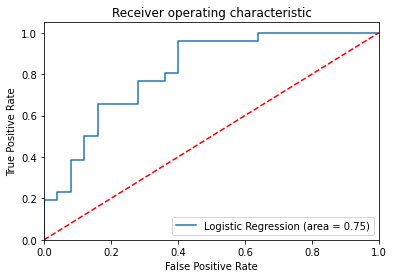

In [24]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [25]:
skl_pred = logreg.predict(curr_teams[["scaled_pointsFor", "scaled_moves", "playoffSeed"]])
curr_teams["skl_pred"] = skl_pred
curr_teams[["abbrev", "playoffSeed", "skl_pred"]]

/tmp/ipykernel_7433/3369455017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_teams["skl_pred"] = skl_pred


,abbrev,playoffSeed,skl_pred
9,Caw,5,1.0
19,TOTY,8,0.0
29,Sith,9,0.0
39,TMB,11,0.0
49,Mill,10,0.0
59,BD,3,1.0
69,Rock,6,0.0
79,2021,2,1.0
89,faq,7,0.0
99,JJJ,12,0.0
